# Machine Learning on Parking Space Occupancy in Dresden

Can we predict the occupation of a parking space ([Centrum-Galerie](https://www.bing.com/maps/default.aspx?q=centrum+galerie+dresden&mkt=de&FORM=HDRSC4)) in Dresden?

Read about it here: http://mechlab-engineering.de/2015/03/vorhersage-der-parkhausbelegung-mit-offenen-daten/

In [1]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

[Here is a map for the parking spaces in Dresden](http://ubahn.draco.uberspace.de/opendata/ui/) and the guys from the Open Knowledge Foundation Dresden (Offenes Dresden) stored the data in a DB and provide a dump of the data.

You can download it:

`http://ubahn.draco.uberspace.de/opendata/dump/parken_dump.csv`


In [2]:
#!rm -rf parken_dump.csv
#!wget http://ubahn.draco.uberspace.de/opendata/dump/parken_dump.csv

### Read the data and process it

In [3]:
data = pd.read_csv('parken_dump.csv', encoding='latin1')

Calc the occupation ([ger] Belegung)

In [4]:
data['Belegung'] = 100.0-data['free']/data['count']*100.0

Pivot the data

In [5]:
ppDD = data.pivot(index='time', columns='name', values='Belegung')

In [6]:
# Define index and names
ppDD.index = pd.DatetimeIndex(ppDD.index)
ppDD.index.name = 'Zeit'
ppDD.columns.name = 'Parkplatz'

print('Daten von %s/%s bis %s/%s' % (ppDD.index[0].month, ppDD.index[0].year, ppDD.index[-1].month, ppDD.index[-1].year)) 

Daten von 4/2014 bis 5/2015


### Wir nehmen nur von 04/2014 - 04/2015

In [7]:
# Wir nehmen nur ein gesamtes Jahr
ppDD = ppDD['2014-04-14':'2015-04-13']

In [8]:
# format the percent without digits
ppDD = ppDD.applymap(lambda x: float('%.0f' % x))

# and limit it between 0...100%
ppDD = ppDD.applymap(lambda x: min(max(x, 0.0), 100.0))

In [9]:
ppDD.tail(3)

Parkplatz,Altmarkt,Altmarkt - Galerie,An der Frauenkirche,Bühlau,Centrum-Galerie,City Center,Cossebaude,Ferdinandplatz,Flutrinne,Frauenkirche Neumarkt,...,Schießgasse,Semperoper,Taschenbergpalais,Terrassenufer,Terrassenufer Bus,Theresienstraße,Wiener Platz/Hbf.,Wiesentorstraße,World Trade Center,Wöhrl - Florentinum
Zeit,,,,,,,,,,,,,,,,,,,,,
2015-04-13 23:15:06,8,NaN,7,0,11,54,5,1,NaN,4,...,NaN,17,23,20,27,14,43,17,9,11
2015-04-13 23:30:07,7,NaN,6,0,11,54,5,1,NaN,4,...,NaN,16,23,20,27,14,43,17,9,11
2015-04-13 23:45:06,6,NaN,6,0,11,54,5,1,NaN,4,...,NaN,16,22,20,27,14,43,17,9,11


# Predict for the Centrum-Galerie Dresden

In [10]:
centrumGalerie = ppDD[['Centrum-Galerie']].dropna()

Ok, take a look at the TimeSeries

In [11]:
# function to plot timeseries with weekend
def plotbelegung(df, which, fromdate, todate):
    if fromdate=='':
        fromdate=df.index[0]
    if todate=='':
        todate=df.index[-1]

    weekend = df[fromdate:todate].index[df[fromdate:todate].index.weekday>4]
    ax = df[fromdate:todate][which].plot(figsize=(9,6), ylim=(0, 130), alpha=0.9, rot=0, title='Auslastung Parkhaus Centrum Galerie Dresden %s bis %s' % (fromdate, todate))
    
    if not df.index.freqstr: # Wenn DataFrame keine Frequenz hat
        ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0,1,2,3,4,5,6),interval=2))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d.'))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\nSa/So'))
        ax.xaxis.grid(True, which="minor")
        ax.xaxis.grid(False, which="major")
    
    plt.ylabel('%')
    
    for w in weekend[::10]:
        plt.axvline(w, c='k', alpha=0.08, zorder=-1)
        
    return plt

<module 'matplotlib.pyplot' from '/Users/paul/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

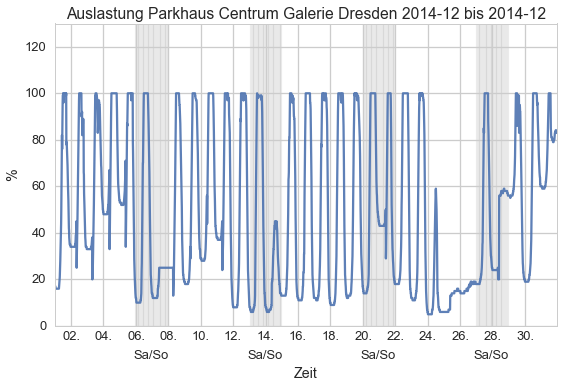

In [12]:
plotbelegung(centrumGalerie, 'Centrum-Galerie', '2014-12', '2014-12')

# Let's do some Machine Learning on that

## Labels

Label ist die Belegung des Parkhauses

In [13]:
centrumGalerie['Belegung'] = centrumGalerie['Centrum-Galerie']#.apply(lambda x: round(x/10.0)*10.0)

## Features

* Uhrzeit
* Wochentag
* Monat
* Verkaufsoffener Sonntag?
* nächster Tag Feiertag? (Deutschland)
* übernächster Tag auch noch Feiertag? (Deutschland)
* Ferien (Deutschland)
* spezielles Event in Galerien oder Stadt oder Kultur
* nächster Tag Feiertag? (Tschechien)
* übernächster Tag auch noch Feiertag? (Tschechien)
* Ferien (Tschechien)
* Wetter

Wir haben nicht alle Features. Aber wenigstens die wichtigsten.

### Wochentag

Es ist wichtig, ob Montag oder Samstag oder Sonntag ist.

In [14]:
centrumGalerie['Wochentag'] = centrumGalerie.index.dayofweek

### Uhrzeit

Dann ist es natürlich extrem wichtig, ob es in der Nacht ist oder tagsüber.

In [15]:
centrumGalerie['Uhrzeit'] = centrumGalerie.index.hour*60.0 + centrumGalerie.index.minute

### Verkaufsoffener Sonntag

Waren in Dresden: 13. April 2014, 5. Oktober 2014, 7. Dezember 2014, 21. Dezember 2014

In [16]:
offeneSonntage = pd.to_datetime(['2014-04-13','2014-10-05','2014-12-07','2014-12-21'])

In [17]:
def isoffenersonntag(serie):
    isoffen = False
    for offene in offeneSonntage:
        if serie.date() == offene.date():
            isoffen=True

    if isoffen:
        return 1
    else:
        return 0

In [18]:
sonntagsseries = pd.Series(centrumGalerie.index, name='offeneSonntage', index=centrumGalerie.index).apply(isoffenersonntag)
centrumGalerie['offenerSonntag'] = sonntagsseries

In [19]:
centrumGalerie[centrumGalerie.offenerSonntag==1].head(5)

Parkplatz,Centrum-Galerie,Belegung,Wochentag,Uhrzeit,offenerSonntag
Zeit,,,,,
2014-10-05 00:00:05,16,16,6,0,1
2014-10-05 00:15:06,15,15,6,15,1
2014-10-05 00:30:05,15,15,6,30,1
2014-10-05 00:45:04,15,15,6,45,1
2014-10-05 01:00:05,15,15,6,60,1


### Feiertage

Wenn ein Feiertag naht, dann gehen auch mehr Leute in die Stadt. Genauso nach einem Feiertag. Deshalb ist das ein Feature.

Get them from http://www.feiertage.net

In [20]:
feiertage = pd.read_csv('Sachsen2014.csv', index_col=0, parse_dates=True, sep=';', dayfirst=True)
feiertage = feiertage.append(pd.read_csv('Sachsen2015.csv', index_col=0, parse_dates=True, sep=';', dayfirst=True))
feiertage = feiertage.append(pd.read_csv('Sachsen2016.csv', index_col=0, parse_dates=True, sep=';', dayfirst=True))

In [21]:
feiertage

,Feiertage,Bundesland
Tag,,
2014-01-01,Neujahr,Sachsen
2014-04-18,Karfreitag,Sachsen
2014-04-21,Ostermontag,Sachsen
2014-05-01,Maifeiertag,Sachsen
2014-05-29,Christi Himmelfahrt,Sachsen
2014-06-09,Pfingstmontag,Sachsen
2014-06-19,Fronleichnam,Sachsen
2014-10-03,Tag der Deutschen Einheit,Sachsen
2014-10-31,Reformationstag,Sachsen


Mit [numpy.busday_count](http://docs.scipy.org/doc/numpy/reference/generated/numpy.busday_count.html) bekommen wir die Anzahl der Werktage bis zum nächsten Feiertag, weil die Leute ja vor einem langen Wochenende immer noch mal richtig einkaufen gehen.

In [22]:
def shoppingdaystonextfeiertag(df):
    diffs = []
    for feiertag in feiertage.index:
        diff = np.busday_count(df.date(), feiertag.date(), weekmask='Mon Tue Wed Thu Fri Sat')
        #print('%s bis %s: %i Arbeitstage' % (feiertag, df, diff)) 
        diffs.append(diff)
        
    try:
        return min([d for d in diffs if d>=0])
    except:
        return 100 # wenn kein Feiertag gefunden

In [23]:
feiertagseries = pd.Series(centrumGalerie.index, name='Feiertage', index=centrumGalerie.index).apply(shoppingdaystonextfeiertag)
centrumGalerie['bisFeiertag'] = feiertagseries

In [24]:
def shoppingdaysafterfeiertag(df):
    diffs = []
    for feiertag in feiertage.index:
        diff = np.busday_count(feiertag.date(), df.date(), weekmask='Mon Tue Wed Thu Fri Sat')
        #print('%s bis %s: %i Arbeitstage' % (feiertag, df, diff)) 
        diffs.append(diff)
        
    try:
        return min([d for d in diffs if d>=0])
    except:
        return 100 # wenn kein Feiertag gefunden

In [25]:
feiertagseries = pd.Series(centrumGalerie.index, name='Feiertage', index=centrumGalerie.index).apply(shoppingdaysafterfeiertag)
centrumGalerie['nachFeiertag'] = feiertagseries

In [26]:
centrumGalerie.groupby([centrumGalerie.index.year, centrumGalerie.index.month, centrumGalerie.index.day]).first()

Parkplatz  Centrum-Galerie  Belegung  Wochentag  Uhrzeit  offenerSonntag  \
2014 4 14               17        17          0        0               0   
       15               12        12          1        0               0   
       16               15        15          2        0               0   
       17               69        69          3        0               0   
       18               18        18          4        0               0   
       19               21        21          5        0               0   
       20               19        19          6        0               0   
       21               20        20          0        0               0   
       22               21        21          1        0               0   
       23               19        19          2        0               0   
       24               29        29          3        0               0   
       25               22        22          4        0               0   
       26               15        15          5        0               0   
       27               95        95          6        0               0   
       28               95        95          0        0               0   
       29                8         8          1        0               0   
       30               12        12          2        0               0   
     5 1                15        15          3        0               0   
       2                23        23          4        0               0   
       3                22        22          5        0               0   
       4                17        17          6        0               0   
       5                26        26          0        0               0   
       6                22        22          1        0               0   
       7                44        44          2        0               0   
       8                20        20          3        0               0   
       9                20        20          4        0               0   
       10               27        27          5        0               0   
       11               27        27          6        0               0   
       12               27        27          0        0               0   
       13               30        30          1        0               0   
...                    ...       ...        ...      ...             ...   
2015 3 15               10        10          6        0               0   
       16               13        13          0        0               0   
       17                8         8          1        0               0   
       18                9         9          2        0               0   
       19               18        18          3        0               0   
       20               19        19          4        0               0   
       21               26        26          5        0               0   
       22               18        18          6        0               0   
       23               15        15          0        0               0   
       24               17        17          1        0               0   
       25               14        14          2        0               0   
       26               17        17          3        0               0   
       27                9         9          4        0               0   
       28               11        11          5        0               0   
       29               10        10          6        0               0   
       30               15        15          0        0               0   
       31               15        15          1        0               0   
     4 1                10        10          2        0               0   
       2                 7         7          3        0               0   
       3                 6         6          4        0               0   
       4                13        13          5 

### Featurevector

In [27]:
featurevector = ['Wochentag','Uhrzeit','offenerSonntag','bisFeiertag','nachFeiertag']

OK, nun haben wir Labels und Features fertig.

Nun können wir Test und Trainingsdatensatz erstellen.

## Train some Machine Learning Classifiers

In [28]:
labels = centrumGalerie['Belegung'].values
np.shape(labels)

(34525,)

In [29]:
features = centrumGalerie[featurevector].values
np.shape(features)

(34525, 5)

In [30]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [31]:
# Import some Models to cycle through
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Split into test and training set

To get an accuracy score, we need to split our dataset in a training and a test set. We train with the training set and test the model later with the part of the test set.

In [32]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [33]:
np.shape(labels_test)

(6905,)

### Test some models with standard parameter set

In [38]:
for Model in [KNeighborsClassifier, GaussianNB, RandomForestClassifier, DecisionTreeClassifier, DecisionTreeRegressor]:

    modelname = str(Model).split('.')[-1][:-2]
    #print modelname
    
    t0 = time.time()
    
    clf = Model().fit(features_train, labels_train)
    tt = time.time()
    
    labels_predict = clf.predict(features_test).astype('int')
    tp = time.time()
    
    score = accuracy_score(labels_predict, labels_test)

    print('%.3f Accuracy Score by %s (Fit Time: %.2fs, Predict Time: %.2fs)' % (score, modelname, tt-t0, tp-tt))

0.048 Accuracy Score by KNeighborsClassifier (Fit Time: 0.03s, Predict Time: 0.09s)
0.038 Accuracy Score by GaussianNB (Fit Time: 0.02s, Predict Time: 0.06s)
0.420 Accuracy Score by RandomForestClassifier (Fit Time: 0.57s, Predict Time: 0.11s)
0.429 Accuracy Score by DecisionTreeClassifier (Fit Time: 0.14s, Predict Time: 0.01s)
0.435 Accuracy Score by DecisionTreeRegressor (Fit Time: 0.08s, Predict Time: 0.00s)


These accuracy scores don't look that amazing, but remember, we try to predict the occupation of a park house by 1% precision. In reality, it doesn't matter if our model predicts 15% and the real value is 16%, but the accuracy score gives a penalty as false prediction. We don't care. :)

### DecisionTreeRegressor looks good and is fast, let's try some parameters

Because it is a regression (output of the prediction are integer) it might fit the data better than a classifier. So we test the the predicted labels with the test labels with the $R^2$ score (coefficient of determination).

In [140]:
print('max_depth\tmin_samples_leaf\tR2_score (higher is better)')
maxscore = 0.8
for md in range(10, 50):
    for mins in range(40, 60):
        classifier = DecisionTreeRegressor(max_depth=md, min_samples_leaf=mins).fit(features_train, labels_train)
        labels_predict = classifier.predict(features_test)
        #labels_rounded = [round(label/10.0)*10.0 for label in labels_predict]
        score = r2_score(labels_test, labels_predict)
        if score>maxscore:
            print('%i\t\t\t%i\t\t\t%.3f' % (md, mins, score))
            maxscore=score

max_depth	min_samples_leaf	R2_score (higher is better)
10			40			0.805
11			40			0.811
12			40			0.818
13			40			0.823
14			40			0.830
15			40			0.837
16			40			0.842
17			40			0.845
18			40			0.846
19			40			0.846
20			40			0.847
21			40			0.848


A high $R^2$-score is better, but if we have a high `max_depth` and low `min_samples_leaf`, we might overfit the dataset. The score is not everything. See [Tips on Practical Use of Decision Trees](http://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)

## Model

In [141]:
classifier = DecisionTreeRegressor(max_depth=21, min_samples_leaf=40).fit(features_train, labels_train)

### Overfit test

One can check for overfitting by just test the model with the training features. If the score is very high (and the score with the test features is low), it is likely, that the model is overfitted.

In [142]:
# Let's check if we overfit. If, the accuracy with the training set is very high, with the test set very low.
labels_predict_overfittest = classifier.predict(features_train).astype('int')
score = accuracy_score(labels_train, labels_predict_overfittest)
print('%.3f Accuracy Score with training data' % (score))

if score>0.4:
    print('You probably overfit it!')

0.097 Accuracy Score with training data


### What is the most important feature for the model

In [143]:
importances = classifier.feature_importances_

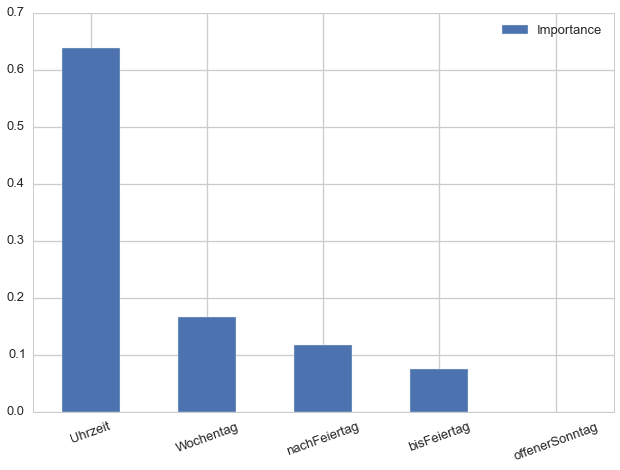

In [144]:
featureimportance = pd.DataFrame(index=featurevector, data=importances, columns=['Importance']).sort('Importance', ascending=False).plot(kind='bar', rot=20)

Obviously it is the time of the day (`Minuten` since midnight), the calender week, the days until the next holiday (because people tend to go shopping if the weekend is long) and for sure the day of the week (because saturday is shopping day!).

In [145]:
labels_predict = classifier.predict(features_test).astype('int')

In [146]:
r2_score(labels_test, labels_predict)

0.8470874600370899

### Let's take a look at the confusion matrix

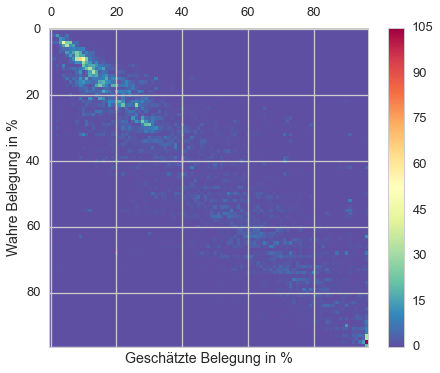

In [147]:
cm = confusion_matrix(labels_predict, labels_test)

plt.matshow(cm, cmap=plt.cm.Spectral_r, interpolation='none')
plt.colorbar(shrink=0.8)
plt.ylabel(u'Wahre Belegung in %')
plt.xlabel(u'Geschätzte Belegung in %')

As you can see, the confusion matrix looks pretty good. That's not perfect, but take into account, that we just have a few features for such a complex scenario like inner-city parking space occupation.

# Predict

Here we predict it for the whole dataset

In [148]:
def predictBelegung(df):
    features = df[featurevector].values
    prediction = int(classifier.predict([features]))
    return prediction

Fire it on the whole Dataset

In [149]:
centrumGalerie['Vorhersage'] = centrumGalerie.apply(predictBelegung, axis=1)

In [150]:
centrumGalerie.head(5)

Parkplatz,Centrum-Galerie,Belegung,Wochentag,Uhrzeit,offenerSonntag,bisFeiertag,nachFeiertag,Vorhersage
Zeit,,,,,,,,
2014-04-14 00:00:07,17,17,0,0,0,4,88,17
2014-04-14 00:15:04,17,17,0,15,0,4,88,17
2014-04-14 00:30:04,17,17,0,30,0,4,88,17
2014-04-14 00:45:04,17,17,0,45,0,4,88,17
2014-04-14 01:00:05,17,17,0,60,0,4,88,17


In [151]:
centrumGalerie['Vorhersage'] = pd.rolling_mean(centrumGalerie['Vorhersage'], 8).shift(-4)

<module 'matplotlib.pyplot' from '/Users/paul/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

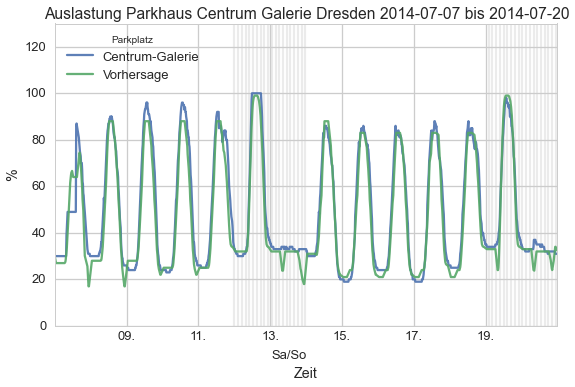

In [152]:
plotbelegung(centrumGalerie, ['Centrum-Galerie','Vorhersage'], '2014-07-07', '2014-07-20')

## Let's test some predictions

In [153]:
featurevector

['Wochentag', 'Uhrzeit', 'offenerSonntag', 'bisFeiertag', 'nachFeiertag']

### Beispiel 1

* Samstag (0=Mo, 1=Di, 2=Mi, 3=Do, 4=Fr, 5=Sa, 6=So)
* 15Uhr (`15h` nach 0Uhr)
* kein verkaufsoffener Sonntag
* 5 Tage bis zum nächsten Feiertag
* 3 Tage nach einem Feiertag

In [154]:
print('%i%% Belegung' % classifier.predict([5, 15*60, 0, 5, 3]))

99% Belegung


### Beispiel 2

* Sonntag (0=Mo, 1=Di, 2=Mi, 3=Do, 4=Fr, 5=Sa, 6=So)
* 15Uhr (`15h` nach 0Uhr)
* kein verkaufsoffener Sonntag
* 15 Werktage bis zum nächsten Feiertag
* 1 Tag nach einem Feiertag

In [155]:
print('%i%% Belegung' % classifier.predict([6, 15*60, 1, 15, 1]))

16% Belegung


### Beispiel 3

* Mittwoch (0=Mo, 1=Di, 2=Mi, 3=Do, 4=Fr, 5=Sa, 6=So)
* 6Uhr (`6h` nach 0Uhr)
* kein verkaufsoffener Sonntag
* 20 Tage bis zum nächsten Feiertag
* 1 Tag nach einem Feiertag

In [156]:
print('%i%% Belegung' % classifier.predict([2, 6*60, 0, 20, 1]))

18% Belegung


# If we want to predict the future, let's create it

In [157]:
future = pd.DataFrame(index=pd.date_range('2015-04-14', '2016-01-01', freq='30Min'))
future.index.name = 'date'
future['Wochentag'] = future.index.dayofweek
#future['KW'] = future.index.week
future['Uhrzeit'] = future.index.hour*60.0 + future.index.minute
feiertagseries = pd.Series(future.index, name='Feiertage', index=future.index).apply(shoppingdaystonextfeiertag)
future['bisFeiertag'] = feiertagseries
feiertagseries = pd.Series(future.index, name='Feiertage', index=future.index).apply(shoppingdaysafterfeiertag)
future['nachFeiertag'] = feiertagseries
sonntagsseries = pd.Series(future.index, name='offeneSonntage', index=future.index).apply(isoffenersonntag)
future['offenerSonntag'] = sonntagsseries

### And predict the occupancy of the parking-space `Centrum-Galerie` with the future features

In [158]:
future['Vorhersage'] = future.apply(predictBelegung, axis=1)

In [159]:
future['Vorhersage'] = pd.rolling_mean(future['Vorhersage'], 8).shift(-4)

In [160]:
future.tail(5)

,Wochentag,Uhrzeit,bisFeiertag,nachFeiertag,offenerSonntag,Vorhersage
date,,,,,,
2015-12-31 22:00:00,3,1320,1,4,0,30.75
2015-12-31 22:30:00,3,1350,1,4,0,NaN
2015-12-31 23:00:00,3,1380,1,4,0,NaN
2015-12-31 23:30:00,3,1410,1,4,0,NaN
2016-01-01 00:00:00,4,0,0,0,0,NaN


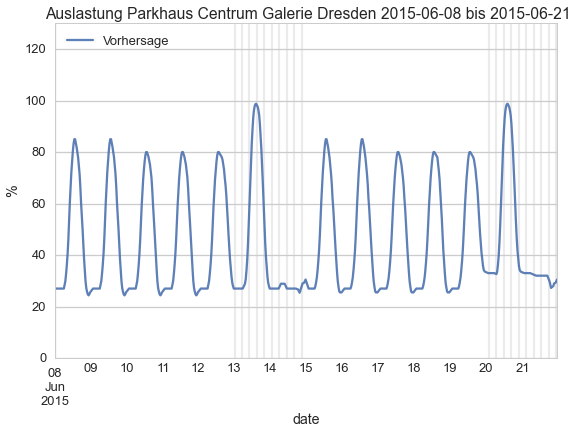

In [168]:
plotbelegung(future, ['Vorhersage'], '2015-06-08', '2015-06-21')
plt.savefig('Centrum-Galerie-Belegung-Vorhersage-2015.png', bbox_inches='tight', dpi=150)

### Save as .csv

In [162]:
future.dropna(inplace=True)
future['Vorhersage'].to_csv('Centrum-Galerie-Belegung-Vorhersage-2015-30min.csv', header=['percentage'] ,float_format='%i')

### Save as sqlite Database

In [163]:
import sqlite3 as db

In [164]:
con = db.connect('./Centrum-Galerie-Belegung-Vorhersage-2015.db')
future['Vorhersage'].to_sql('CentrumGalerieVorhersage2015', con, if_exists='replace')

## Save the Classifier for later use

Later you can load back the pickled model (possibly in another Python process) with:

`with open('classifier.pkl', 'rb') as fid:
    classifier = pickle.load(fid)`

In [165]:
import pickle
with open('./Classifier/DecisionTreeRegressor-CentrumGalerie.pkl', 'wb') as fid:
    pickle.dump(classifier, fid)  

Questions: [@Balzer82](https://twitter.com/Balzer82)